**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
# Unzip the dataset
!unzip "/content/drive/MyDrive/CNN_assignment.zip" -d "/content/drive/MyDrive/"

Archive:  /content/drive/MyDrive/CNN_assignment.zip
replace /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Importing all the important libraries**

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
# Set the paths to the Train and Test directories
# Using pathlib.Path to create Path objects for the directories
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [6]:
# Verifying the contents
!ls "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


**Create a dataset**

In [7]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# Create the train dataset (80% of the images for training)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,           # Using 20% of the data for validation
    subset="training",
    seed=123,                       # Ensuring reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Create the validation dataset (20% of the images for validation)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,           # Using 20% of the data for validation
    subset="validation",
    seed=123,                       # Ensuring reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# List out all the classes of skin cancer
class_names = train_ds.class_names
print("Class names: ", class_names)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Class names:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

This code defines a function, visualize_classes, which visualizes one instance of each class from a given dataset.

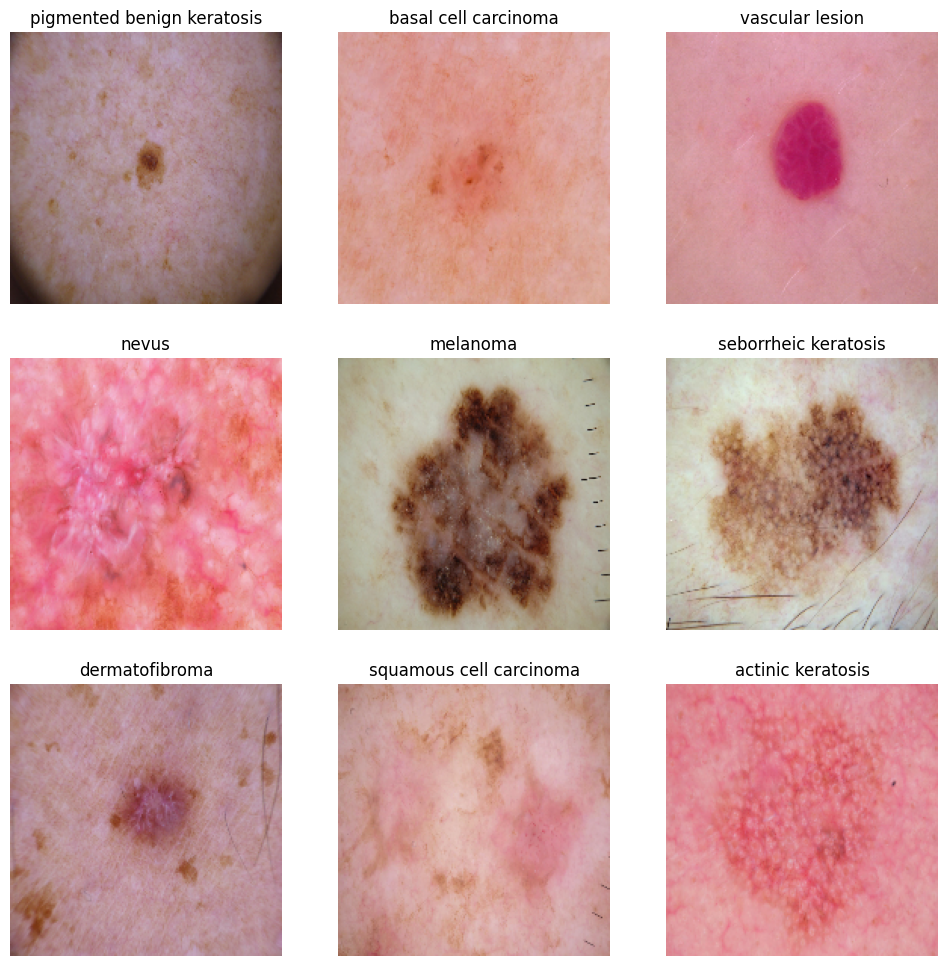

In [10]:
import matplotlib.pyplot as plt

# Creating a function to visualize one instance of each class
def visualize_classes(dataset, class_names):
    plt.figure(figsize=(12, 12))
    class_seen = [False] * len(class_names)  # Track which classes have been visualized
    images_shown = 0

    # Loop through the dataset to get batches of images and labels
    for image_batch, label_batch in dataset:
        for i in range(len(image_batch)):
            label = label_batch[i].numpy()
            if not class_seen[label]:
                plt.subplot(3, 3, images_shown + 1)
                plt.imshow(image_batch[i].numpy().astype("uint8"))
                plt.title(class_names[label])
                plt.axis("off")
                class_seen[label] = True
                images_shown += 1
            if images_shown == len(class_names):  # Stop when all classes are visualized
                break
        if images_shown == len(class_names):
            break

    plt.show()

# Calling the function to visualize from the training or validation dataset
visualize_classes(train_ds, class_names)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Optimize the training dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Optimize the validation dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


**Create the model**

In [13]:
# Define the CNN model with normalization
model = Sequential([
    # Rescale pixel values from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation='relu'),

    # Output layer (for 9 classes)
    layers.Dense(9, activation='softmax')
])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 218ms/step - accuracy: 0.2072 - loss: 2.1365 - val_accuracy: 0.3803 - val_loss: 1.8139
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3639 - loss: 1.7648 - val_accuracy: 0.4877 - val_loss: 1.5323
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5003 - loss: 1.4531 - val_accuracy: 0.5034 - val_loss: 1.4105
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5215 - loss: 1.3470 - val_accuracy: 0.4743 - val_loss: 1.5197
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5146 - loss: 1.3739 - val_accuracy: 0.5414 - val_loss: 1.3756
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5399 - loss: 1.3094 - val_accuracy: 0.5459 - val_loss: 1.3791
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5933 - loss: 1.1642 - val_accuracy: 0.5638 - val_loss: 1.4339
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6021 - loss: 1.1264 - val_accuracy: 0.5503 -

**Visualizing the results**

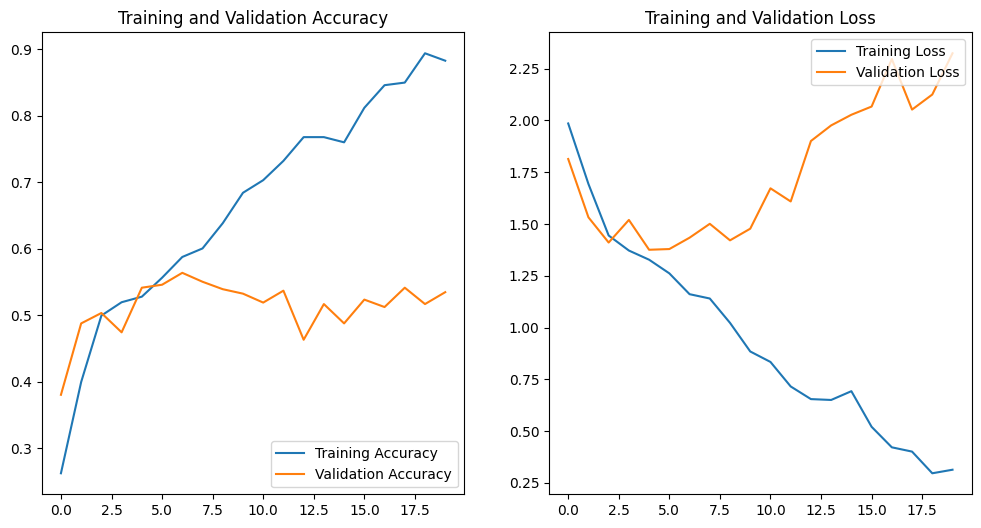

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Ensure the epochs range matches the length of the training

plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()

**Findings from the First Model Execution:**

**Accuracy**:

The model started with a low accuracy (~21%) in the first epoch but gradually improved, reaching around 88% accuracy on the training set by the 20th epoch.
However, the validation accuracy remained much lower, peaking at around 53-56% by the 20th epoch, indicating the model is struggling to generalize well to the validation data.

**Loss**:

The training loss consistently decreased as expected, showing that the model is learning well from the training data.
The validation loss initially decreased but started increasing after epoch 6, which is an indication that the model is starting to overfit. By the end of 20 epochs, the validation loss had risen to 2.3244, while the training loss was significantly lower.

**Overfitting**:

There is a clear sign of overfitting. The model fits the training data very well, but fails to generalize to unseen validation data. This is indicated by the increasing validation loss and stagnant validation accuracy after around 6-7 epochs.

**Imbalance in Performance:**

There is a growing gap between training accuracy (88%) and validation accuracy (53%), further indicating that the model is overly focused on the training data and not performing as well on new data.

In this section, **Data augmentation** is applied to the training dataset to improve generalization and prevent overfitting. The augmentation includes random flipping, rotation, zooming, and contrast adjustment. These transformations are applied on the fly during training using a tf.keras.Sequential model.

In [17]:
# Add data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Prefetch and cache the augmented dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
augmented_train_ds = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




In this section, a function is used to **visualize the augmented images**. It randomly applies the same data augmentation techniques (flip, rotation, zoom, contrast) on a sample of images from the training dataset and displays them.

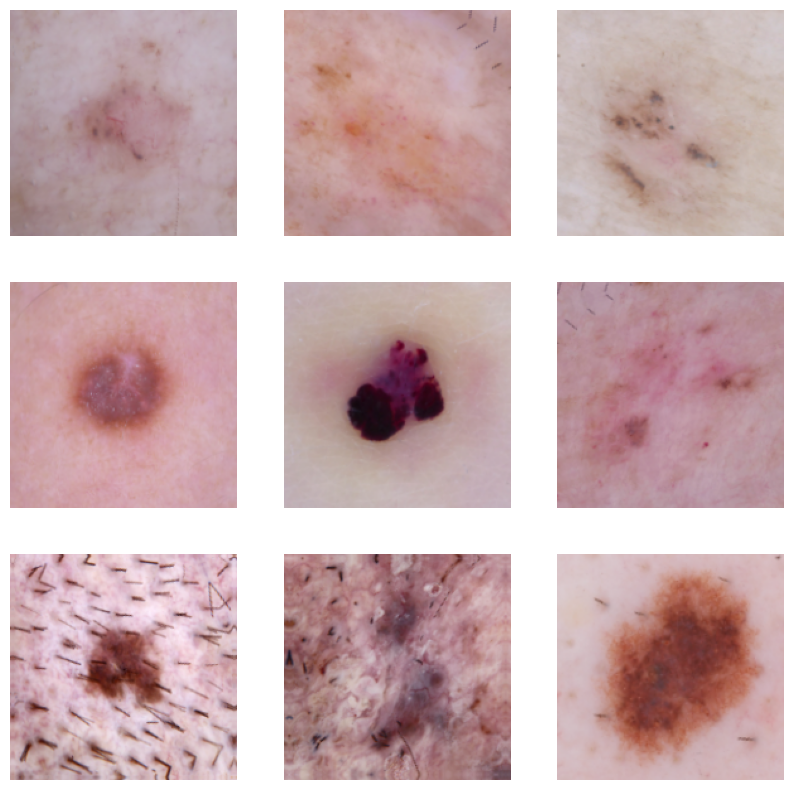

In [18]:
import matplotlib.pyplot as plt

# Function to visualize augmented images
def visualize_augmented_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_image = data_augmentation(images[i: i+1])
            plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_image[0].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

# Visualize augmented images
visualize_augmented_images(train_ds)


In [19]:
# Train the model again with the augmented data
history_augmented = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.4964 - loss: 1.8564 - val_accuracy: 0.5324 - val_loss: 1.4708
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5588 - loss: 1.2630 - val_accuracy: 0.5548 - val_loss: 1.3215
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5969 - loss: 1.1283 - val_accuracy: 0.5593 - val_loss: 1.3662
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6601 - loss: 0.9183 - val_accuracy: 0.5593 - val_loss: 1.4018
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6845 - loss: 0.9003 - val_accuracy: 0.5682 - val_loss: 1.7449
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7224 - loss: 0.7497 - val_accuracy: 0.4944 - val_loss: 1.9200
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7374 - loss: 0.7016 - val_accuracy: 0.5078 - val_loss: 2.0586
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7913 - loss: 0.6010 - val_accuracy: 0.5190 - 

**Findings from the Second Model Execution**

It looks like model is overfitting based on the results you posted.

**Training Accuracy vs. Validation Accuracy:**

The training accuracy is improving significantly, reaching high values (e.g., 98% by epoch 19).
However, the validation accuracy is stagnating or slightly decreasing, suggesting that the model is not generalizing well to the validation set.

**Training Loss vs. Validation Loss:**

The training loss is decreasing significantly, while the validation loss is increasing (e.g., a validation loss of 5.9886 by epoch 20). This is a strong indicator of overfitting, as the model is fitting the training data too well but failing to perform on unseen data.



In this section, a Convolutional Neural Network (CNN) model is defined with added **Dropout layers** to **reduce overfitting**. Dropout layers randomly deactivate a fraction of the neurons during training, which helps the model generalize better to new data by preventing reliance on specific neurons.

In [21]:
# Updated CNN model with Dropout layers
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),  # Add dropout to regularize the model

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps
    layers.Flatten(),

    # Fully connected layer with Dropout
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting

    # Output layer (9 classes)
    layers.Dense(len(class_names), activation='softmax')
])

# Print the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.1909 - loss: 2.7375 - val_accuracy: 0.1924 - val_loss: 2.1009
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2228 - loss: 2.0513 - val_accuracy: 0.2908 - val_loss: 2.0886
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2764 - loss: 1.9668 - val_accuracy: 0.4564 - val_loss: 1.8675
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3920 - loss: 1.7756 - val_accuracy: 0.4497 - val_loss: 1.7183
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4612 - loss: 1.6319 - val_accuracy: 0.4653 - val_loss: 1.6232
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4046 - loss: 1.6678 - val_accuracy: 0.4362 - val_loss: 1.5619
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4427 - loss: 1.4978 - val_accuracy: 0.4989 - val_loss: 1.5058
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4718 - loss: 1.5002 - val_accuracy: 0.5011 - v

**Visualizing the results**

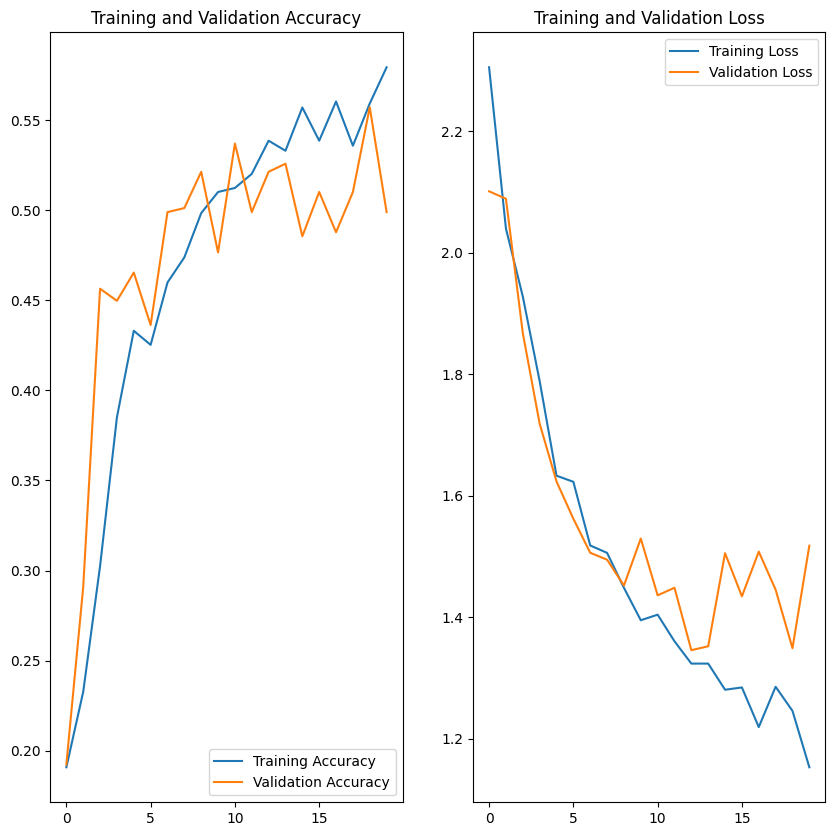

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)  # If you trained for 20 epochs, adjust as needed

plt.figure(figsize=(10, 10))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


**Findings from the Third Model Execution**


**Training Loss & Accuracy:**

The training accuracy started at 19.09% and gradually improved to 58.03% by the 20th epoch.
The training loss decreased consistently from 2.7375 to 1.1553, indicating the model was learning over time.

**Validation Loss & Accuracy:**

The validation accuracy started at 19.24% and fluctuated, ending at 49.89% by the 20th epoch.
The validation loss fluctuated, starting at 2.1009 and ending at 1.5175, with periods of reduction but no consistent decrease.

**Evidence of Underfitting or Overfitting:**

*Underfitting*:

At the beginning, both training and validation accuracy were low, but by the 20th epoch, the training accuracy was much higher than the validation accuracy.
Training loss decreased significantly, but validation loss did not show a steady improvement.
The validation accuracy did not keep up with the increase in training accuracy, suggesting that the model might be underfitting initially and failing to generalize well.

*Overfitting:*

There is some evidence of potential overfitting towards the later epochs as the gap between training and validation accuracy widened, and the validation loss didn’t improve as much. This suggests that the model may have started to memorize the training data without generalizing well on the validation data.

**Do you think there is some improvement now as compared to the previous model run?**

Based on the comparison between previous model (with augmented data) and this model (with dropout layers applied), here are the key observations:

*Model 1 (Augmented Data):*

Training Accuracy: Reached up to 98.21%.

Validation Accuracy: Around 49.22%.

Training Loss: Decreased significantly (to 0.08), indicating that the model is fitting the training data very well.

Validation Loss: Increased significantly over time (up to 5.98), showing clear signs of overfitting.

*Model 2 (Dropout Layers):*

Training Accuracy: Reached up to 58.03%.

Validation Accuracy: Around 49.89%.

Training Loss: Reached 1.15, indicating the model is learning, but at a slower pace compared to Model 1.

Validation Loss: 1.51, which is more stable compared to Model 1 but still shows room for improvement.

**Improvement Comparison:**

Overfitting:

In Model 1, there was severe overfitting, where the training accuracy became extremely high while the validation performance dropped significantly.

In Model 2, by introducing dropout layers, the model's training and validation accuracies are more aligned, reducing the overfitting observed in Model 1.
Validation Accuracy:

Model 2 has a more consistent validation accuracy (hovering around 49-55%), while Model 1 started off well but saw a significant drop in validation accuracy due to overfitting.
Training Accuracy:

While Model 1 showed very high training accuracy, it was due to overfitting, whereas Model 2's training accuracy reflects a more realistic fit, although it could improve further.

**Conclusion**:

Yes, Model 2 shows improvement compared to Model 1 in terms of reducing overfitting and stabilizing the training and validation performance. However, there is still room for improvement in validation accuracy and further tuning or changes to the model architecture or data augmentation might be needed.

**Find the distribution of classes in the training dataset.**

**Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In this section, the original training dataset is being loaded, and the class distribution of images is analyzed before any data augmentation.

Class distribution before augmentation:
Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64


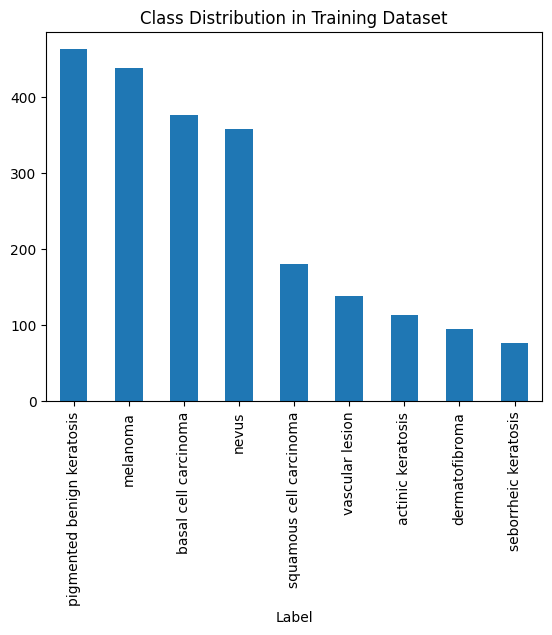

In [25]:
import pandas as pd
import os
import glob

# Path to training dataset
path_to_training_dataset = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

# Extract all the original image paths (excluding augmented images in the 'output' folder)
path_list_original = [x for x in glob.glob(os.path.join(path_to_training_dataset, '*', '*.jpg'))]

# Extract class labels for each image from the directory structure
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in path_list_original]

# Create a DataFrame for the original images
original_df = pd.DataFrame({
    'Path': path_list_original,
    'Label': lesion_list_original
})

# Check the class distribution in the original dataset
class_distribution = original_df['Label'].value_counts()
print("Class distribution before augmentation:")
print(class_distribution)

# Visualize the class distribution using a bar plot
class_distribution.plot(kind='bar', title='Class Distribution in Training Dataset')
plt.show()


**Based on the output of the above code, you can write your findings**:

*Which class has the least number of samples?*
Identify the class with the lowest sample count from the class_distribution dictionary.

Class with the least number of samples:
**Seborrheic Keratosis**: It has only 77 samples, making it the class with the fewest samples.

*Which classes dominate the data in terms of the proportionate number of samples?*
Identify the class with the highest sample count from the class_distribution dictionary.

Classes dominating the data in terms of the number of samples:
**Pigmented Benign Keratosis and Melanoma** have the most samples with 462 and 438 images, respectively.

**Rectify Class Imbalance Using Augmentor**
Once you've identified class imbalance, we can use the Augmentor library to generate more samples for the underrepresented classes.

**First, install Augmentor:**

In [26]:
!pip install Augmentor


This section demonstrates how data augmentation is used to rectify class imbalance in the dataset:

**Augmentor Pipeline**: For each class in the dataset, an Augmentor pipeline is applied to create additional training samples using techniques such as rotation, horizontal flipping, and random zoom. These augmentations help diversify the dataset and mitigate the class imbalance by artificially expanding the number of samples per class.

**Sample Generation**: The code generates 500 new samples per class through these transformations. The number of samples can be adjusted depending on the degree of imbalance and the desired balance level.

**Re-check Class Distribution**: After the augmentation process, the class distribution is re-calculated and visualized to ensure that the classes are more balanced. This post-augmentation visualization provides a clear view of the effect of the augmentation process on the dataset.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x793D5DEC3A60>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x793D5DC12D70>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x793D5E16B4C0>: 100%|██████████| 500/500 [00:21<00:00, 23.46 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x793D5DDA81F0>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x793D5DC65060>: 100%|██████████| 500/500 [01:35<00:00,  5.25 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x793D5DE826B0>: 100%|██████████| 500/500 [00:20<00:00, 24.17 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x793DC01E2AA0>: 100%|██████████| 500/500 [00:45<00:00, 10.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x793D5DE833A0>: 100%|██████████| 500/500 [00:18<00:00, 26.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x793D5DC50310>: 100%|██████████| 500/500 [00:19<00:00, 25.21 Samples/s]


Class distribution after augmentation:
Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64


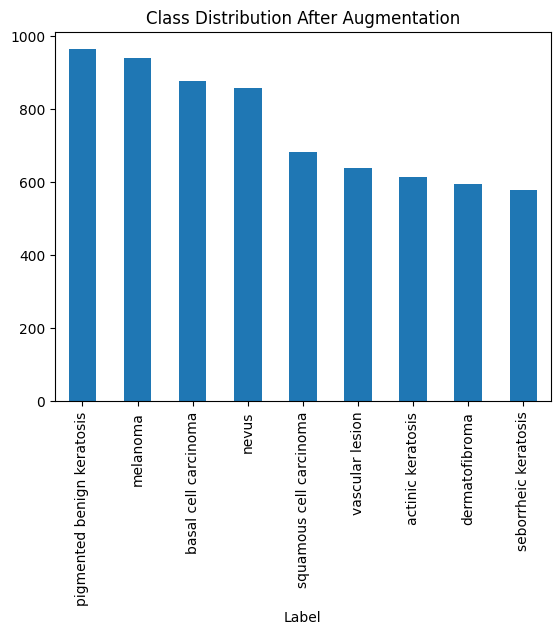

In [27]:
import Augmentor

# Rectify class imbalance by augmenting each class to ensure each class has a sufficient number of samples
for class_name in original_df['Label'].unique():
    class_path = os.path.join(path_to_training_dataset, class_name)  # Path to each class directory
    p = Augmentor.Pipeline(class_path)  # Create Augmentor pipeline for each class

    # Apply transformations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)  # Rotation
    p.flip_left_right(probability=0.5)  # Flip horizontally
    p.zoom_random(probability=0.5, percentage_area=0.8)  # Random zoom

    # Generate 500 new samples per class (you can adjust this number as needed)
    p.sample(500)

# After applying augmentation, re-check the class distribution
augmented_image_paths = [x for x in glob.glob(os.path.join(path_to_training_dataset, '*', 'output', '*.jpg'))]
augmented_labels = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in augmented_image_paths]

# Create a new dataframe with augmented data
df_augmented = pd.DataFrame({'Path': augmented_image_paths, 'Label': augmented_labels})

# Combine the original and augmented data
combined_df = pd.concat([original_df, df_augmented], ignore_index=True)

# Check the class distribution again after augmentation
new_class_distribution = combined_df['Label'].value_counts()
print("Class distribution after augmentation:")
print(new_class_distribution)

# Visualize the updated class distribution
new_class_distribution.plot(kind='bar', title='Class Distribution After Augmentation')
plt.show()


**Findings After Augmentation**:

*Class with the least number of samples after augmentation*:

**Seborrheic Keratosis**: Although it has increased in size, it still has the least number of samples with 577 images.

**Are the classes more balanced now?**

Yes, the classes are more balanced compared to the initial distribution. The number of samples across all classes has increased, especially for the underrepresented classes. However, Pigmented Benign Keratosis still slightly dominates with 962 samples, but the difference is now much smaller compared to before the augmentation.
Overall, the dataset appears more balanced, which should help improve the model's ability to generalize across all classes.

**Train the model on the data created using Augmentor**

In [28]:
batch_size = 32
img_height = 180
img_width = 180
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")


**Create a training and validation dataset**

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,  # 20% of data used for validation
    subset="training",     # This ensures only the training data is loaded
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,  # 20% of data used for validation
    subset="validation",   # This ensures only the validation data is loaded
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Model Creation**

In [30]:
# Define the CNN model with normalization and dropout layers
model = tf.keras.Sequential([
    # Rescaling to normalize pixel values between 0 and 1
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),  # Dropout to prevent overfitting

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),  # Dropout to prevent overfitting

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),  # Dropout to prevent overfitting

    # Fourth convolutional block (New addition for extra complexity)
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps
    tf.keras.layers.Flatten(),

    # Fully connected layer with dropout
    tf.keras.layers.Dense(256, activation='relu'),  # Increased size for complexity
    tf.keras.layers.Dropout(0.5),  # Dropout to prevent overfitting in dense layers

    # Output layer (assuming 9 classes)
    tf.keras.layers.Dense(9, activation='softmax')  # Update number of classes if needed
])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,699,401 (21.74 MB)

 Trainable params: 5,699,401 (21.74 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [32]:
epochs = 50  # increased this to 50 as mentioned in the instructions

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - accuracy: 0.1438 - loss: 2.2703 - val_accuracy: 0.1656 - val_loss: 2.1503
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 260ms/step - accuracy: 0.2176 - loss: 2.0246 - val_accuracy: 0.2673 - val_loss: 1.9920
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 231ms/step - accuracy: 0.3179 - loss: 1.7860 - val_accuracy: 0.3801 - val_loss: 1.6647
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 250ms/step - accuracy: 0.3721 - loss: 1.6143 - val_accuracy: 0.3727 - val_loss: 1.5688
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 256ms/step - accuracy: 0.3988 - loss: 1.5716 - val_accuracy: 0.4083 - val_loss: 1.5151
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 238ms/step - accuracy: 0.4143 - loss: 1.4701 - val_accuracy: 0.4276 - val_loss: 1.4506
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.4549 - loss: 1.4227 - val_accuracy: 0.4402 - val_loss: 1.4231
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.4804 - loss: 1

**Visualize the model results**

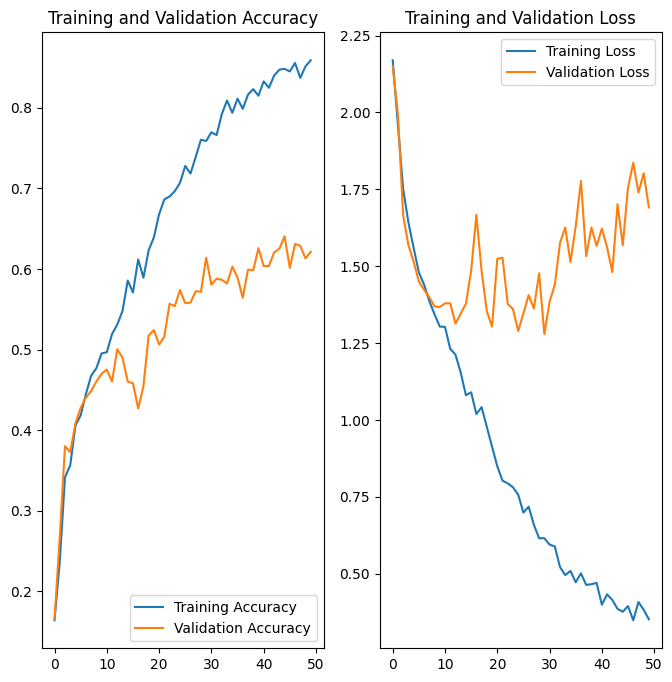

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Findings and Analysis**:

**Training Accuracy:** The training accuracy improved steadily throughout the 50 epochs, starting from 14% and reaching 85% by the end. This indicates that the model is successfully learning the patterns in the training data.

**Validation Accuracy:** The validation accuracy also improved, although not as dramatically as the training accuracy. It started at around 16% and reached 62% by the end. This suggests that the model is generalizing better but still shows **signs of overfitting**, as the training accuracy is much higher than the validation accuracy.

**Training Loss**: The training loss decreased significantly over the epochs, starting at 2.27 and reducing to 0.36 by the end. This confirms that the model is learning effectively on the training data.

**Validation Loss**: The validation loss fluctuated and did not decrease as consistently as the training loss. It started at 2.15 and ended at 1.69, indicating that while the model improved, it still struggled with the validation data.

**Overfitting/Underfitting:**
*Overfitting*: There is evidence of mild overfitting. The gap between the training accuracy (85%) and validation accuracy (62%) is notable. The validation loss fluctuated and even increased in the later epochs, while the training loss consistently decreased.

This indicates that while the model is learning patterns in the training data, it is not generalizing perfectly to unseen data.

**Suggestion: To mitigate overfitting, more regularization strategies can be used, such as increasing dropout, adding L2 regularization, or applying data augmentation more extensively.**

**Underfitting:** There is no strong evidence of underfitting. The model's performance on the training data is very high, which means the model has sufficient capacity to learn the patterns.

**Impact of Class Rebalance:**

*Class Balance Improvement:* After rebalancing the class distribution using augmentation, there was some improvement in the model's performance. The training accuracy increased steadily, and the validation accuracy showed a better trend compared to previous runs without rebalancing.

**Result:** Class rebalance helped in ensuring that the model does not focus disproportionately on the more frequent classes, leading to more balanced learning.

**Further steps:** While class rebalance has had a positive effect, further improvements may be achieved by fine-tuning the data augmentation strategy or adjusting the model architecture to handle more complex patterns in the data.

**This code snippet demonstrates to visualize and predict a single test image using the trained CNN model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


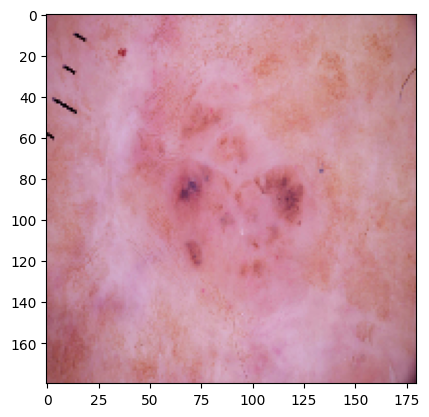

In [39]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )